In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_1294301/1135360396.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


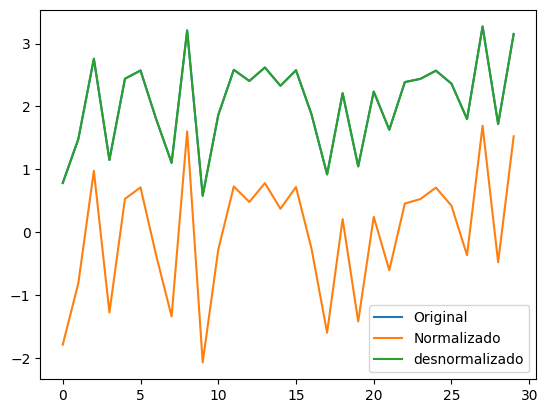

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 5.50 MiB/s, done.


Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:39:46.141264: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:39:46.196212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:39:46.196253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:39:46.197644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:39:46.205935: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:39:46.207203: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:39:47.427211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 1s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.512809,0.228340,0.181683,0.452758,0.076525,0.458091,0.573248,0.096947,0.104455,0.276631,0.018005,0.278784,135.140280,321.530019
model_1_0_8,0.474659,0.218851,0.157484,0.473229,0.082517,0.463724,0.590200,0.093320,0.109230,0.287258,-0.058890,0.289493,134.989498,321.379237
model_1_0_7,0.412866,0.213187,0.119644,0.497020,0.092223,0.467086,0.616708,0.089106,0.118007,0.303683,-0.183443,0.306046,134.767086,321.156825
model_1_0_4,0.055450,-0.019692,-0.039101,0.042848,0.148364,0.605333,0.727912,0.169565,0.166555,0.385180,-0.903858,0.388178,133.816176,320.205916
model_1_0_6,0.050394,-0.020107,-0.054390,0.010838,0.149158,0.605579,0.738622,0.175236,0.175968,0.386210,-0.914049,0.389215,133.805500,320.195239
model_1_0_5,0.056071,-0.021754,-0.040984,0.039349,0.148266,0.606557,0.729231,0.170185,0.167994,0.385054,-0.902607,0.388050,133.817491,320.207230
model_1_0_3,0.033901,-0.028341,-0.047848,0.022286,0.151749,0.610467,0.734039,0.173208,0.168318,0.389549,-0.947293,0.392581,133.771061,320.160800
model_1_0_2,0.009420,-0.043520,-0.059649,-0.002397,0.155594,0.619478,0.742306,0.177580,0.172106,0.394454,-0.996637,0.397524,133.721013,320.110752
model_1_0_1,-0.008880,-0.051068,-0.070640,-0.019960,0.158468,0.623960,0.750005,0.180692,0.174596,0.398081,-1.033523,0.401179,133.684402,320.074141
model_1_0_0,-0.025272,-0.060369,-0.077340,-0.034793,0.161043,0.629481,0.754699,0.183319,0.177170,0.401302,-1.066565,0.404425,133.652166,320.041905


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_2,0.597970,0.317621,0.321489,0.654817,0.063148,0.405089,0.475311,0.068008,0.104912,0.251293,0.189658,0.253249,135.524539,321.914278
model_1_1_3,0.630303,0.311018,0.302860,0.671834,0.058070,0.409010,0.488361,0.064655,0.098880,0.240976,0.254829,0.242852,135.692224,322.081963
model_1_1_4,0.652216,0.307413,0.293800,0.678804,0.054628,0.411150,0.494708,0.063282,0.096433,0.233726,0.298997,0.235545,135.814427,322.204167
model_1_1_5,0.664011,0.302896,0.285599,0.673580,0.052775,0.413831,0.500453,0.064311,0.096789,0.229728,0.322773,0.231516,135.883438,322.273178
model_1_1_1,0.551429,0.298919,0.289399,0.615633,0.070459,0.416192,0.497791,0.075728,0.110430,0.265441,0.095848,0.267506,135.305458,321.695197
model_1_1_6,0.681949,0.293858,0.274613,0.676828,0.049957,0.419196,0.508149,0.063671,0.094615,0.223511,0.358929,0.225251,135.993173,322.382912
model_1_1_8,0.701421,0.286144,0.256374,0.686276,0.046899,0.423776,0.520926,0.061810,0.092701,0.216561,0.398178,0.218247,136.119527,322.509267
model_1_1_7,0.699972,0.282918,0.252263,0.683229,0.047126,0.425691,0.523806,0.062410,0.092060,0.217086,0.395256,0.218776,136.109843,322.499582
model_1_1_9,0.721228,0.275984,0.245645,0.704259,0.043788,0.429807,0.528441,0.058267,0.089636,0.209255,0.438100,0.210884,136.256803,322.646542
model_1_1_0,0.541772,0.235888,0.198562,0.616200,0.071975,0.453610,0.561424,0.075616,0.101525,0.268282,0.076384,0.270370,135.262860,321.652599


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_0,0.734319,0.282907,0.262773,0.619980,0.041731,0.425697,0.516443,0.035195,0.084278,0.204283,0.464488,0.205872,136.353004,322.742744
model_1_2_1,0.748394,0.275397,0.267217,0.621375,0.039521,0.430155,0.513330,0.035066,0.080003,0.198798,0.492857,0.200345,136.461865,322.851604
model_1_2_2,0.757171,0.257470,0.226134,0.626940,0.038142,0.440798,0.542109,0.034551,0.079313,0.195300,0.510548,0.196820,136.532880,322.922620
model_1_2_3,0.769000,0.249521,0.198521,0.643083,0.036284,0.445517,0.561452,0.033056,0.078328,0.190484,0.534390,0.191966,136.632756,323.022495
model_1_2_4,0.782096,0.228955,0.168762,0.649211,0.034227,0.457726,0.582299,0.032488,0.079247,0.185005,0.560788,0.186445,136.749485,323.139225
model_1_2_5,0.793170,0.216130,0.116404,0.650939,0.032488,0.465339,0.618978,0.032328,0.077613,0.180243,0.583108,0.181646,136.853797,323.243536
model_1_2_6,0.802647,0.205911,0.059853,0.652893,0.030999,0.471405,0.658592,0.032147,0.074929,0.176065,0.602210,0.177435,136.947601,323.337340
model_1_2_7,0.809475,0.186080,-0.020242,0.631216,0.029926,0.483178,0.714701,0.034155,0.073484,0.172992,0.615974,0.174339,137.018030,323.407769
model_1_2_8,0.814004,0.168077,-0.105528,0.604932,0.029215,0.493865,0.774445,0.036589,0.071854,0.170924,0.625102,0.172254,137.066143,323.455883
model_1_2_9,0.817982,0.148141,-0.186870,0.577114,0.028590,0.505700,0.831427,0.039165,0.070868,0.169086,0.633121,0.170402,137.109385,323.499125


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_0,0.819518,0.139213,-0.196291,0.777848,0.028349,0.511001,0.838027,0.052843,0.070310,0.168371,0.636217,0.169682,137.126336,323.516076
model_1_3_1,0.821837,0.128909,-0.196408,0.770554,0.027985,0.517117,0.838108,0.054578,0.070009,0.167286,0.640891,0.168588,137.152199,323.541938
model_1_3_2,0.825963,0.113626,-0.213701,0.760179,0.027337,0.526190,0.850223,0.057046,0.069356,0.165338,0.649207,0.166625,137.199057,323.588796
model_1_3_3,0.827756,0.094821,-0.236744,0.745593,0.027055,0.537353,0.866365,0.060515,0.069026,0.164484,0.652820,0.165764,137.219766,323.609506
model_1_3_4,0.826988,0.089992,-0.237022,0.742044,0.027176,0.540220,0.866560,0.061360,0.069434,0.164850,0.651273,0.166133,137.210874,323.600613
model_1_3_5,0.827179,0.067619,-0.269486,0.719869,0.027146,0.553502,0.889302,0.066634,0.069369,0.164759,0.651657,0.166041,137.213079,323.602818
model_1_3_6,0.824925,0.056436,-0.289270,0.700452,0.027500,0.560140,0.903160,0.071253,0.069201,0.165830,0.647115,0.167120,137.187170,323.576909
model_1_3_7,0.818264,0.033096,-0.307616,0.676228,0.028546,0.573996,0.916012,0.077015,0.071976,0.168955,0.633689,0.170270,137.112486,323.502225
model_1_3_8,0.814527,0.025934,-0.325914,0.651238,0.029133,0.578248,0.928830,0.082960,0.072134,0.170683,0.626157,0.172012,137.071779,323.461519
model_1_3_9,0.810218,0.025673,-0.341616,0.618384,0.029810,0.578403,0.939830,0.090774,0.071965,0.172655,0.617471,0.173998,137.025843,323.415582


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.820435,0.188056,-0.037811,0.700980,0.028205,0.482005,0.727008,0.051428,0.074300,0.167943,0.638064,0.169250,137.136515,323.526255
model_1_4_8,0.819748,0.187483,-0.039000,0.704438,0.028313,0.482345,0.727841,0.050833,0.074448,0.168264,0.636679,0.169574,137.128879,323.518618
model_1_4_7,0.816880,0.174925,-0.046418,0.702861,0.028763,0.489800,0.733037,0.051104,0.074510,0.169597,0.630900,0.170917,137.097314,323.487054
model_1_4_6,0.819716,0.140872,-0.215859,0.721698,0.028318,0.510016,0.851734,0.047864,0.073825,0.168279,0.636615,0.169589,137.128528,323.518267
model_1_4_5,0.812601,0.125285,-0.225693,0.732496,0.029435,0.519269,0.858623,0.046007,0.075238,0.171568,0.622274,0.172903,137.051113,323.440853
model_1_4_4,0.812347,0.076368,-0.331355,0.750867,0.029475,0.548308,0.932642,0.042848,0.074393,0.171684,0.621762,0.173020,137.048403,323.438142
model_1_4_3,0.812224,0.065592,-0.340091,0.753646,0.029495,0.554705,0.938761,0.042370,0.074327,0.171740,0.621513,0.173077,137.047090,323.436830
model_1_4_2,0.808208,0.049453,-0.324019,0.768706,0.030125,0.564286,0.927503,0.039780,0.074400,0.173567,0.613419,0.174918,137.004767,323.394506
model_1_4_0,0.809755,0.029218,-0.338859,0.795487,0.029882,0.576298,0.937899,0.035174,0.072155,0.172865,0.616538,0.174211,137.020972,323.410711
model_1_4_1,0.809367,0.023741,-0.354364,0.789749,0.029943,0.579549,0.948760,0.036161,0.072597,0.173041,0.615756,0.174388,137.016898,323.406637


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.839245,0.230780,-0.004141,0.776094,0.025250,0.456642,0.703422,0.015082,0.070797,0.158904,0.675978,0.160140,137.357827,323.747566
model_1_5_7,0.836088,0.227332,0.006874,0.790594,0.025746,0.458689,0.695705,0.014105,0.071444,0.160456,0.669616,0.161705,137.318938,323.708677
model_1_5_8,0.837865,0.223222,-0.006168,0.787617,0.025467,0.461129,0.704842,0.014306,0.070790,0.159584,0.673196,0.160826,137.340730,323.730469
model_1_5_6,0.836532,0.219754,-0.001722,0.799602,0.025676,0.463188,0.701727,0.013498,0.071149,0.160239,0.670511,0.161486,137.324363,323.714102
model_1_5_5,0.835699,0.216729,-0.005219,0.801889,0.025807,0.464984,0.704177,0.013344,0.071283,0.160647,0.668830,0.161897,137.314190,323.703929
model_1_5_4,0.834787,0.214827,-0.009963,0.802872,0.025951,0.466112,0.707500,0.013278,0.071504,0.161092,0.666992,0.162346,137.303118,323.692857
model_1_5_3,0.833974,0.213094,-0.010868,0.802541,0.026078,0.467141,0.708134,0.013300,0.071755,0.161488,0.665353,0.162745,137.293302,323.683041
model_1_5_2,0.832428,0.210887,-0.010968,0.801306,0.026321,0.468451,0.708204,0.013383,0.072009,0.162238,0.662239,0.163500,137.274773,323.664512
model_1_5_1,0.830829,0.206228,-0.018775,0.798008,0.026572,0.471217,0.713673,0.013606,0.072430,0.163010,0.659016,0.164278,137.255779,323.645518
model_1_5_0,0.829124,0.203590,-0.023776,0.794280,0.026840,0.472784,0.717177,0.013857,0.072824,0.163830,0.655577,0.165105,137.235712,323.625451


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.844764,0.214744,-0.106253,0.795674,0.024383,0.466162,0.774953,0.027850,0.069288,0.156152,0.687102,0.157367,137.427700,323.817439
model_1_6_1,0.848193,0.200058,-0.249364,0.784565,0.023845,0.474880,0.875205,0.029364,0.068825,0.154418,0.694013,0.155620,137.472368,323.862107
model_1_6_2,0.848960,0.191391,-0.290920,0.779506,0.023724,0.480025,0.904316,0.030054,0.068803,0.154027,0.695560,0.155226,137.482502,323.872241
model_1_6_3,0.849403,0.181983,-0.340938,0.775188,0.023655,0.485610,0.939355,0.030642,0.068777,0.153801,0.696454,0.154998,137.488384,323.878123
model_1_6_4,0.843993,0.068178,-0.899265,0.707723,0.024505,0.553170,1.330475,0.039838,0.070052,0.156539,0.685549,0.157757,137.417797,323.807536
model_1_6_5,0.833827,-0.025922,-1.259946,0.627457,0.026101,0.609031,1.583139,0.050779,0.071045,0.161559,0.665057,0.162817,137.291533,323.681273
model_1_6_6,0.832362,-0.028772,-1.277102,0.609214,0.026331,0.610723,1.595157,0.053265,0.071198,0.162270,0.662105,0.163533,137.273982,323.663722
model_1_6_7,0.834957,-0.082705,-1.442662,0.574808,0.025924,0.642741,1.711135,0.057955,0.069843,0.161009,0.667335,0.162262,137.305178,323.694917
model_1_6_8,0.836373,-0.099546,-1.487634,0.572382,0.025701,0.652738,1.742639,0.058285,0.069412,0.160317,0.670189,0.161564,137.322415,323.712155
model_1_6_9,0.836980,-0.104883,-1.499432,0.570589,0.025606,0.655906,1.750904,0.058530,0.069189,0.160019,0.671413,0.161264,137.329846,323.719585


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.838861,0.003799,-0.297844,0.570906,0.025311,0.591388,0.909167,0.077830,0.067768,0.159093,0.675205,0.160331,137.353063,323.742802
model_1_7_8,0.839967,-0.000567,-0.335138,0.586727,0.025137,0.593980,0.935292,0.074960,0.068123,0.158547,0.677433,0.159780,137.366828,323.756567
model_1_7_7,0.839597,-0.001425,-0.330126,0.587283,0.025195,0.594489,0.931781,0.074859,0.068199,0.158729,0.676688,0.159965,137.362218,323.751957
model_1_7_6,0.840873,-0.006995,-0.366647,0.597823,0.024995,0.597796,0.957364,0.072947,0.068090,0.158097,0.679261,0.159327,137.378194,323.767933
model_1_7_3,0.840998,-0.013734,-0.546875,0.628725,0.024975,0.601796,1.083618,0.067342,0.069367,0.158035,0.679512,0.159265,137.379763,323.769503
model_1_7_4,0.840383,-0.024629,-0.522904,0.617743,0.025072,0.608264,1.066826,0.069334,0.069072,0.158340,0.678273,0.159572,137.372043,323.761782
model_1_7_5,0.840711,-0.025320,-0.525512,0.617211,0.025020,0.608674,1.068653,0.069431,0.068928,0.158177,0.678934,0.159408,137.376157,323.765897
model_1_7_2,0.839274,-0.044746,-0.736566,0.648576,0.025246,0.620206,1.216501,0.063742,0.070353,0.158889,0.676038,0.160126,137.358197,323.747936
model_1_7_1,0.840086,-0.092850,-1.029931,0.674947,0.025118,0.648763,1.422009,0.058959,0.070259,0.158487,0.677674,0.159721,137.368326,323.758065
model_1_7_0,0.840009,-0.127087,-1.371754,0.710429,0.025130,0.669087,1.661463,0.052523,0.070307,0.158526,0.677517,0.159759,137.367354,323.757093


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.849052,0.029904,-0.265032,0.804245,0.023710,0.575891,0.886181,0.035830,0.066618,0.153980,0.695746,0.155178,137.483726,323.873465
model_1_8_9,0.829405,0.024250,-0.328730,0.629171,0.026796,0.579248,0.930803,0.067875,0.066555,0.163695,0.656144,0.164969,137.239006,323.628745
model_1_8_3,0.836207,0.020281,-0.359264,0.687143,0.025728,0.581604,0.952193,0.057264,0.066926,0.160398,0.669855,0.161646,137.320386,323.710125
model_1_8_4,0.836124,0.019924,-0.371716,0.684205,0.025741,0.581815,0.960916,0.057802,0.066848,0.160439,0.669688,0.161687,137.319376,323.709115
model_1_8_8,0.836599,0.019443,-0.374879,0.667561,0.025666,0.582101,0.963131,0.060849,0.066251,0.160206,0.670644,0.161453,137.325176,323.714916
model_1_8_1,0.835800,0.019314,-0.369583,0.690835,0.025792,0.582178,0.959421,0.056589,0.067154,0.160597,0.669033,0.161847,137.315418,323.705157
model_1_8_2,0.835703,0.018612,-0.365223,0.687837,0.025807,0.582594,0.956367,0.057137,0.067071,0.160645,0.668839,0.161895,137.314244,323.703983
model_1_8_7,0.835871,0.018443,-0.375538,0.666518,0.025780,0.582695,0.963593,0.061039,0.066432,0.160562,0.669178,0.161812,137.316292,323.706032
model_1_8_5,0.836685,0.017916,-0.366285,0.675903,0.025652,0.583007,0.957111,0.059322,0.066624,0.160164,0.670819,0.161410,137.326235,323.715974
model_1_8_6,0.835929,0.017027,-0.374272,0.670858,0.025771,0.583535,0.962706,0.060245,0.066608,0.160534,0.669295,0.161783,137.316996,323.706735


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.837241,0.017133,-0.354864,0.749362,0.025565,0.583472,0.949111,0.021562,0.065578,0.159891,0.671938,0.161136,137.333047,323.722786
model_1_9_1,0.838140,0.014204,-0.355195,0.742923,0.025424,0.585211,0.949343,0.022116,0.065447,0.159449,0.673752,0.160689,137.344135,323.733875
model_1_9_2,0.837560,0.008295,-0.340492,0.722747,0.025515,0.588719,0.939043,0.023852,0.065590,0.159734,0.672582,0.160977,137.336976,323.726715
model_1_9_3,0.838532,-0.024658,-0.344874,0.634698,0.025362,0.608281,0.942112,0.031427,0.066440,0.159256,0.674540,0.160495,137.348973,323.738713
model_1_9_6,0.825523,-0.033356,-0.321172,0.435679,0.027406,0.613445,0.925508,0.048548,0.069090,0.165547,0.648320,0.166835,137.194006,323.583745
model_1_9_4,0.828126,-0.035780,-0.326845,0.492179,0.026997,0.614884,0.929482,0.043688,0.068710,0.164307,0.653567,0.165586,137.224076,323.613815
model_1_9_5,0.823905,-0.037797,-0.313067,0.442863,0.027660,0.616081,0.919831,0.047930,0.068987,0.166313,0.645058,0.167607,137.175541,323.565280
model_1_9_7,0.820571,-0.042798,-0.327150,0.369987,0.028184,0.619050,0.929696,0.054200,0.069214,0.167880,0.638338,0.169186,137.138031,323.527770
model_1_9_8,0.815106,-0.047253,-0.325439,0.306555,0.029042,0.621695,0.928498,0.059657,0.069602,0.170417,0.627322,0.171743,137.078024,323.467763
model_1_9_9,0.813946,-0.049591,-0.328097,0.285438,0.029224,0.623083,0.930359,0.061474,0.069536,0.170951,0.624985,0.172281,137.065521,323.455261


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.821034,-0.076544,-0.408698,0.862761,0.028111,0.639083,0.986822,0.013181,0.068914,0.167663,0.639271,0.168968,137.143197,323.532936
model_1_10_1,0.828940,-0.102597,-0.504251,0.871477,0.026869,0.654549,1.053759,0.012344,0.067838,0.163918,0.655207,0.165193,137.233561,323.623300
model_1_10_2,0.830772,-0.107632,-0.522610,0.872611,0.026581,0.657538,1.066620,0.012235,0.067548,0.163038,0.658899,0.164307,137.255094,323.644834
model_1_10_3,0.834800,-0.121806,-0.571461,0.876293,0.025949,0.665952,1.100841,0.011882,0.066868,0.161086,0.667018,0.162339,137.303274,323.693013
model_1_10_4,0.835750,-0.126104,-0.581616,0.874073,0.025799,0.668504,1.107955,0.012095,0.066794,0.160622,0.668933,0.161872,137.314812,323.704551
model_1_10_5,0.837348,-0.132780,-0.606366,0.875292,0.025548,0.672467,1.125293,0.011978,0.066532,0.159838,0.672155,0.161082,137.334369,323.724108
model_1_10_6,0.838972,-0.139597,-0.627910,0.876034,0.025293,0.676514,1.140385,0.011906,0.066268,0.159039,0.675427,0.160276,137.354431,323.744171
model_1_10_7,0.840336,-0.148869,-0.660132,0.876525,0.025079,0.682018,1.162957,0.011859,0.066066,0.158363,0.678177,0.159596,137.371451,323.761190
model_1_10_8,0.841540,-0.152868,-0.674296,0.875804,0.024890,0.684393,1.172879,0.011929,0.065875,0.157765,0.680604,0.158993,137.386590,323.776329
model_1_10_9,0.851641,-0.195520,-0.790268,0.867866,0.023303,0.709713,1.254120,0.012691,0.064830,0.152654,0.700964,0.153842,137.518321,323.908061


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.841918,0.012574,-0.250118,0.663237,0.024830,0.586179,0.875733,0.062094,0.064461,0.157577,0.681366,0.158803,137.391365,323.781105
model_1_11_8,0.842328,0.008961,-0.255530,0.667755,0.024766,0.588324,0.879525,0.061261,0.064508,0.157373,0.682192,0.158597,137.396559,323.786298
model_1_11_7,0.842778,0.001486,-0.282332,0.676234,0.024695,0.592761,0.898300,0.059697,0.064682,0.157148,0.683099,0.158371,137.402273,323.792012
model_1_11_6,0.851934,-0.053069,-0.387284,0.759672,0.023257,0.625147,0.971821,0.044313,0.064712,0.152503,0.701554,0.153690,137.522274,323.912013
model_1_11_5,0.857036,-0.082980,-0.476514,0.810892,0.022456,0.642904,1.034329,0.034869,0.064315,0.149853,0.711839,0.151019,137.592414,323.982153
model_1_11_4,0.858291,-0.117168,-0.562685,0.834159,0.022259,0.663199,1.094693,0.030578,0.064081,0.149193,0.714369,0.150354,137.610047,323.999786
model_1_11_3,0.858424,-0.121350,-0.572847,0.840293,0.022238,0.665682,1.101812,0.029448,0.064111,0.149124,0.714635,0.150284,137.611917,324.001656
model_1_11_0,0.856520,-0.170318,-0.727143,0.882504,0.022537,0.694751,1.209899,0.021665,0.063845,0.150123,0.710797,0.151291,137.585197,323.974936
model_1_11_2,0.856288,-0.173810,-0.739498,0.873249,0.022573,0.696825,1.218554,0.023371,0.064138,0.150244,0.710330,0.151414,137.581969,323.971709
model_1_11_1,0.855955,-0.181272,-0.754792,0.876191,0.022626,0.701254,1.229268,0.022829,0.064218,0.150418,0.709659,0.151589,137.577340,323.967080


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.860766,-0.041298,-0.428815,0.727181,0.021870,0.618159,1.000915,0.032453,0.062286,0.147885,0.719356,0.149036,137.645277,324.035016
model_1_12_1,0.861975,-0.062963,-0.502947,0.705015,0.021680,0.631021,1.052845,0.035090,0.061967,0.147242,0.721793,0.148387,137.662725,324.052464
model_1_12_2,0.864697,-0.081300,-0.579766,0.677791,0.021252,0.641906,1.106659,0.038328,0.061296,0.145782,0.727280,0.146917,137.702562,324.092301
model_1_12_3,0.867735,-0.102743,-0.654684,0.666980,0.020775,0.654636,1.159140,0.039614,0.060321,0.144136,0.733404,0.145258,137.747980,324.137719
model_1_12_4,0.867992,-0.106851,-0.671371,0.662660,0.020735,0.657075,1.170830,0.040128,0.060255,0.143996,0.733922,0.145117,137.751876,324.141615
model_1_12_5,0.868980,-0.109877,-0.666728,0.664042,0.020580,0.658871,1.167578,0.039964,0.060158,0.143456,0.735913,0.144573,137.766897,324.156636
model_1_12_7,0.869322,-0.109997,-0.714250,0.626123,0.020526,0.658942,1.200868,0.044475,0.061014,0.143269,0.736601,0.144384,137.772113,324.161853
model_1_12_6,0.868934,-0.123103,-0.724715,0.653469,0.020587,0.666722,1.208199,0.041222,0.060201,0.143482,0.735819,0.144599,137.766186,324.155925
model_1_12_8,0.873724,-0.144826,-0.806870,0.611302,0.019835,0.679618,1.265750,0.046238,0.060090,0.140836,0.745475,0.141932,137.840651,324.230390
model_1_12_9,0.872220,-0.165305,-0.862975,0.555489,0.020071,0.691776,1.305053,0.052877,0.059963,0.141672,0.742443,0.142774,137.816969,324.206708


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.869717,-0.218473,-0.975166,0.850496,0.020464,0.723338,1.383645,0.021969,0.060709,0.143052,0.737398,0.144166,137.778176,324.167915
model_1_13_1,0.863101,-0.261731,-0.997649,0.783208,0.021503,0.749018,1.399395,0.031856,0.061338,0.146640,0.724063,0.147781,137.679108,324.068847
model_1_13_2,0.856243,-0.313363,-1.143261,0.720435,0.022580,0.779669,1.501399,0.041080,0.061183,0.150268,0.710240,0.151437,137.581348,323.971087
model_1_13_3,0.852756,-0.326289,-1.146085,0.699174,0.023128,0.787343,1.503377,0.044204,0.061283,0.152080,0.703211,0.153263,137.533406,323.923145
model_1_13_4,0.842562,-0.427771,-1.320269,0.622798,0.024729,0.847587,1.625397,0.055427,0.061112,0.157256,0.682665,0.158479,137.399533,323.789272
model_1_13_5,0.842222,-0.438917,-1.334054,0.615099,0.024783,0.854203,1.635054,0.056559,0.060980,0.157425,0.681979,0.158650,137.395218,323.784958
model_1_13_6,0.841894,-0.448259,-1.354889,0.610147,0.024834,0.859749,1.649649,0.057286,0.060801,0.157589,0.681318,0.158815,137.391063,323.780802
model_1_13_7,0.841161,-0.458542,-1.375539,0.603182,0.024949,0.865853,1.664115,0.058310,0.060686,0.157954,0.679840,0.159183,137.381813,323.771552
model_1_13_8,0.839558,-0.487490,-1.435853,0.588370,0.025201,0.883039,1.706366,0.060486,0.060395,0.158749,0.676609,0.159984,137.361731,323.751470
model_1_13_9,0.831279,-0.578218,-1.588287,0.523198,0.026502,0.936899,1.813149,0.070063,0.060120,0.162793,0.659922,0.164060,137.261104,323.650843


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_8,0.828565,-0.415662,-1.447067,0.721936,0.026928,0.840398,1.714221,0.059217,0.064721,0.164097,0.654450,0.165374,137.229180,323.618919
model_1_14_7,0.827686,-0.415711,-1.455919,0.722214,0.027066,0.840427,1.720422,0.059158,0.064823,0.164517,0.652679,0.165798,137.218955,323.608694
model_1_14_9,0.827559,-0.420547,-1.461740,0.715430,0.027086,0.843298,1.724500,0.060602,0.064848,0.164578,0.652424,0.165859,137.217488,323.607227
model_1_14_6,0.827659,-0.425249,-1.466269,0.724096,0.027070,0.846089,1.727673,0.058757,0.064828,0.164530,0.652626,0.165811,137.218646,323.608385
model_1_14_5,0.829743,-0.449116,-1.434167,0.755719,0.026743,0.860258,1.705184,0.052022,0.063375,0.163532,0.656826,0.164805,137.242976,323.632715
model_1_14_4,0.830794,-0.458372,-1.444100,0.761214,0.026578,0.865752,1.712143,0.050852,0.063209,0.163027,0.658944,0.164296,137.255360,323.645099
model_1_14_2,0.837316,-0.460209,-1.436600,0.794800,0.025553,0.866843,1.706889,0.043700,0.061723,0.159854,0.672089,0.161098,137.333970,323.723709
model_1_14_3,0.831835,-0.462946,-1.471280,0.765449,0.026414,0.868468,1.731183,0.049950,0.062962,0.162525,0.661042,0.163789,137.267702,323.657441
model_1_14_1,0.834599,-0.495078,-1.488768,0.819662,0.025980,0.887543,1.743434,0.038405,0.061437,0.161184,0.666613,0.162438,137.300842,323.690581
model_1_14_0,0.832676,-0.569616,-1.584696,0.834766,0.026282,0.931792,1.810633,0.035188,0.060084,0.162118,0.662737,0.163380,137.277724,323.667463


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  35
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_7,0.660944,-0.373373,-1.180216,-0.891558,0.053257,0.815294,1.527286,0.216243,0.068534,0.230774,0.316590,0.232570,135.865263,322.255002
model_1_15_9,0.641308,-0.374321,-1.251538,-1.030238,0.056341,0.815856,1.577249,0.232097,0.068741,0.237363,0.277012,0.239210,135.752667,322.142406
model_1_15_8,0.643150,-0.376687,-1.251560,-1.015715,0.056052,0.817261,1.577265,0.230436,0.068741,0.236752,0.280724,0.238595,135.762961,322.152700
model_1_15_6,0.663817,-0.383322,-1.158872,-0.864151,0.052805,0.821199,1.512335,0.213109,0.068552,0.229794,0.322381,0.231583,135.882282,322.272021
model_1_15_3,0.731004,-0.403031,-1.023537,-0.331870,0.042252,0.832900,1.417529,0.152259,0.067582,0.205553,0.457805,0.207153,136.328200,322.717939
model_1_15_5,0.673617,-0.403548,-1.141221,-0.790952,0.051266,0.833207,1.499970,0.204741,0.068236,0.226420,0.342134,0.228182,135.941449,322.331188
model_1_15_4,0.699654,-0.410029,-1.108220,-0.586305,0.047176,0.837054,1.476852,0.181346,0.068096,0.217201,0.394616,0.218892,136.107725,322.497464
model_1_15_2,0.753947,-0.416002,-1.022159,-0.141764,0.038648,0.840600,1.416564,0.130526,0.067470,0.196592,0.504050,0.198122,136.506503,322.896242
model_1_15_0,0.791618,-0.419517,-1.108522,0.180041,0.032731,0.842687,1.477063,0.093738,0.065752,0.180918,0.579980,0.182326,136.838847,323.228586
model_1_15_1,0.767325,-0.424505,-1.030379,-0.031068,0.036547,0.845647,1.422322,0.117872,0.066759,0.191173,0.531014,0.192661,136.618308,323.008047


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.786480,-0.112326,-0.509681,0.646496,0.033538,0.660325,1.057563,0.025787,0.067961,0.183135,0.569623,0.184560,136.790130,323.179869
model_1_16_8,0.784441,-0.112861,-0.504704,0.648538,0.033859,0.660642,1.054077,0.025638,0.068105,0.184007,0.565513,0.185439,136.771121,323.160860
model_1_16_5,0.770927,-0.113321,-0.505002,0.666675,0.035981,0.660916,1.054285,0.024315,0.068235,0.189688,0.538274,0.191164,136.649509,323.039248
model_1_16_4,0.768474,-0.114945,-0.503381,0.667327,0.036367,0.661880,1.053150,0.024267,0.068391,0.190700,0.533330,0.192184,136.628207,323.017946
model_1_16_6,0.771148,-0.117047,-0.505820,0.665083,0.035947,0.663127,1.054858,0.024431,0.068384,0.189596,0.538720,0.191071,136.651439,323.041179
model_1_16_7,0.772517,-0.118257,-0.508743,0.660141,0.035732,0.663846,1.056906,0.024792,0.068389,0.189028,0.541479,0.190499,136.663441,323.053181
model_1_16_2,0.727214,-0.128736,-0.460130,0.693055,0.042848,0.670067,1.022851,0.022391,0.070785,0.206996,0.450165,0.208607,136.300216,322.689955
model_1_16_3,0.730521,-0.129528,-0.466372,0.691805,0.042328,0.670537,1.027224,0.022482,0.070540,0.205738,0.456832,0.207339,136.324614,322.714353
model_1_16_1,0.702690,-0.131747,-0.461151,0.693172,0.046700,0.671854,1.023567,0.022382,0.072394,0.216101,0.400735,0.217782,136.128043,322.517782
model_1_16_0,0.698638,-0.132359,-0.456857,0.692516,0.047336,0.672217,1.020559,0.022430,0.072715,0.217568,0.392567,0.219262,136.100968,322.490707


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  39
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.804694,-0.251414,-0.820493,0.672083,0.030677,0.742893,1.275293,0.040651,0.066696,0.175150,0.606337,0.176513,136.968459,323.358199
model_1_17_1,0.810952,-0.277952,-0.899862,0.654889,0.029694,0.758647,1.330893,0.042782,0.066099,0.172321,0.618951,0.173662,137.033596,323.423336
model_1_17_2,0.814427,-0.311749,-0.989410,0.632963,0.029149,0.778711,1.393623,0.045500,0.065720,0.170730,0.625954,0.172058,137.070697,323.460436
model_1_17_3,0.812974,-0.339617,-1.007779,0.606879,0.029377,0.795255,1.406491,0.048734,0.065973,0.171397,0.623026,0.172730,137.055100,323.444839
model_1_17_4,0.810723,-0.372674,-1.026302,0.568040,0.029730,0.814878,1.419467,0.053549,0.066248,0.172425,0.618489,0.173767,137.031174,323.420914
model_1_17_5,0.823585,-0.481328,-1.215799,0.524644,0.027710,0.879380,1.552213,0.058928,0.063850,0.166464,0.644413,0.167759,137.171914,323.561653
model_1_17_6,0.820360,-0.527659,-1.292177,0.480887,0.028217,0.906884,1.605717,0.064353,0.063568,0.167978,0.637913,0.169285,137.135685,323.525424
model_1_17_7,0.824724,-0.568787,-1.340465,0.478689,0.027531,0.931299,1.639544,0.064625,0.062930,0.165925,0.646710,0.167216,137.184873,323.574613
model_1_17_8,0.827645,-0.583463,-1.365940,0.489271,0.027072,0.940012,1.657390,0.063313,0.062736,0.164537,0.652597,0.165817,137.218483,323.608222
model_1_17_9,0.833366,-0.620257,-1.447781,0.509009,0.026174,0.961854,1.714721,0.060866,0.062174,0.161783,0.664129,0.163042,137.285995,323.675734


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


2024-08-25 02:42:10.635987: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  34
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


2024-08-25 02:42:15.233664: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.860037,-0.372066,-2.113383,0.691879,0.021984,0.814518,2.180989,0.060151,0.058804,0.148272,0.717887,0.149425,137.634839,324.024578
model_1_18_8,0.868036,-0.426053,-2.222325,0.729580,0.020728,0.846567,2.257306,0.052791,0.058889,0.143973,0.734009,0.145093,137.752528,324.142267
model_1_18_6,0.867458,-0.445510,-2.157895,0.738841,0.020819,0.858117,2.212171,0.050983,0.059553,0.144288,0.732844,0.145410,137.743788,324.133527
model_1_18_7,0.868297,-0.446410,-2.184785,0.740914,0.020687,0.858651,2.231008,0.050579,0.059515,0.143830,0.734536,0.144949,137.756494,324.146234
model_1_18_4,0.862130,-0.448476,-1.991455,0.725478,0.021656,0.859878,2.095577,0.053592,0.059464,0.147159,0.722106,0.148304,137.664975,324.054714
model_1_18_5,0.868555,-0.463063,-2.229598,0.745933,0.020647,0.868538,2.262400,0.049599,0.059763,0.143689,0.735055,0.144807,137.760410,324.150150
model_1_18_3,0.858617,-0.484037,-1.474870,0.754373,0.022208,0.880989,1.733698,0.047951,0.060192,0.149022,0.715024,0.150182,137.614645,324.004384
model_1_18_2,0.856337,-0.492901,-1.486197,0.747487,0.022566,0.886250,1.741633,0.049296,0.060281,0.150219,0.710429,0.151388,137.582649,323.972388
model_1_18_1,0.843384,-0.577738,-1.548429,0.705713,0.024600,0.936613,1.785228,0.057451,0.060094,0.156845,0.684321,0.158065,137.410001,323.799740
model_1_18_0,0.840860,-0.581591,-1.543652,0.698577,0.024997,0.938901,1.781881,0.058844,0.060338,0.158103,0.679233,0.159334,137.378025,323.767764


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_1,0.858982,-0.378869,-1.893411,0.718445,0.022150,0.818556,2.026895,0.043712,0.058179,0.148830,0.715760,0.149988,137.619812,324.009552
model_1_19_2,0.860420,-0.382431,-1.839802,0.721648,0.021924,0.820671,1.989340,0.043215,0.057587,0.148069,0.718659,0.149221,137.640318,324.030057
model_1_19_0,0.860171,-0.385030,-2.103375,0.757503,0.021963,0.822213,2.173978,0.037648,0.058983,0.148201,0.718158,0.149354,137.636756,324.026495
model_1_19_4,0.868183,-0.418545,-1.876742,0.725501,0.020705,0.842110,2.015217,0.042617,0.056475,0.143892,0.734307,0.145012,137.754766,324.144505
model_1_19_3,0.867570,-0.418780,-1.899944,0.723404,0.020801,0.842249,2.031471,0.042942,0.056397,0.144226,0.733070,0.145349,137.745482,324.135221
model_1_19_5,0.868782,-0.423250,-1.900858,0.724617,0.020611,0.844903,2.032111,0.042754,0.056326,0.143565,0.735514,0.144682,137.763872,324.153611
model_1_19_7,0.857709,-0.545785,-2.169326,0.624646,0.022350,0.917645,2.220179,0.058275,0.057103,0.149500,0.713195,0.150663,137.601846,323.991585
model_1_19_6,0.857705,-0.553106,-2.212127,0.626802,0.022351,0.921991,2.250162,0.057940,0.057260,0.149502,0.713187,0.150665,137.601789,323.991528
model_1_19_8,0.846905,-0.591326,-2.304610,0.555868,0.024047,0.944680,2.314948,0.068953,0.057498,0.155072,0.691418,0.156278,137.455474,323.845214
model_1_19_9,0.843896,-0.600286,-2.274546,0.522708,0.024520,0.949999,2.293887,0.074101,0.057531,0.156588,0.685353,0.157806,137.416552,323.806291


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.810846,-0.268728,-0.942386,0.153193,0.029711,0.753172,1.360682,0.095319,0.059403,0.172369,0.618736,0.173710,137.032470,323.422209
model_1_20_8,0.815810,-0.289633,-1.016629,0.191522,0.028931,0.765582,1.412690,0.091005,0.058988,0.170092,0.628743,0.171416,137.085661,323.475401
model_1_20_7,0.832116,-0.324586,-1.133252,0.315088,0.026370,0.786332,1.494387,0.077096,0.057300,0.162389,0.661609,0.163653,137.271048,323.660787
model_1_20_6,0.834274,-0.330851,-1.167854,0.331898,0.026031,0.790050,1.518627,0.075204,0.057063,0.161342,0.665958,0.162597,137.296921,323.686660
model_1_20_5,0.843866,-0.370240,-1.301460,0.424555,0.024524,0.813434,1.612221,0.064774,0.056461,0.156603,0.685293,0.157822,137.416169,323.805908
model_1_20_4,0.851710,-0.462160,-1.672733,0.542834,0.023292,0.868001,1.872305,0.051460,0.056157,0.152618,0.701104,0.153806,137.519260,323.908999
model_1_20_3,0.849944,-0.490459,-1.779318,0.552536,0.023570,0.884801,1.946970,0.050368,0.056440,0.153525,0.697544,0.154719,137.495580,323.885319
model_1_20_2,0.849988,-0.499593,-1.815813,0.559127,0.023563,0.890223,1.972535,0.049626,0.056564,0.153502,0.697632,0.154697,137.496163,323.885902
model_1_20_1,0.845248,-0.580902,-2.148633,0.566882,0.024307,0.938492,2.205683,0.048753,0.057208,0.155908,0.688079,0.157122,137.433950,323.823689
model_1_20_0,0.844969,-0.589483,-2.201547,0.570162,0.024351,0.943586,2.242750,0.048384,0.057158,0.156049,0.687517,0.157263,137.430349,323.820088


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  52
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.881898,-0.149401,-0.910995,0.825665,0.018551,0.682334,1.338692,0.035677,0.056091,0.136201,0.761950,0.137261,137.974493,324.364232
model_1_21_7,0.879744,-0.151773,-0.929010,0.828916,0.018889,0.683742,1.351312,0.035012,0.056370,0.137438,0.757609,0.138507,137.938344,324.328083
model_1_21_8,0.880254,-0.151774,-0.927857,0.828434,0.018809,0.683743,1.350504,0.035111,0.056303,0.137145,0.758638,0.138213,137.946854,324.336594
model_1_21_5,0.874423,-0.161655,-0.946414,0.838071,0.019725,0.689609,1.363503,0.033139,0.056679,0.140445,0.746883,0.141538,137.851749,324.241488
model_1_21_3,0.873408,-0.163374,-0.950928,0.838513,0.019884,0.690629,1.366665,0.033048,0.056588,0.141012,0.744838,0.142109,137.835653,324.225393
model_1_21_4,0.874113,-0.163452,-0.948784,0.838088,0.019773,0.690675,1.365163,0.033135,0.056514,0.140618,0.746259,0.141713,137.846826,324.236566
model_1_21_6,0.874889,-0.163767,-0.949722,0.837094,0.019652,0.690862,1.365821,0.033338,0.056598,0.140184,0.747824,0.141275,137.859197,324.248936
model_1_21_2,0.872773,-0.164077,-0.948656,0.838899,0.019984,0.691047,1.365074,0.032969,0.056644,0.141365,0.743558,0.142465,137.825648,324.215388
model_1_21_1,0.872023,-0.165036,-0.950719,0.839264,0.020102,0.691616,1.366519,0.032894,0.056717,0.141781,0.742046,0.142884,137.813888,324.203627
model_1_21_0,0.868983,-0.189154,-1.031682,0.850668,0.020579,0.705933,1.423235,0.030561,0.056381,0.143455,0.735919,0.144571,137.766942,324.156681


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.876617,-0.112851,-0.904217,0.792946,0.019380,0.660636,1.333944,0.025275,0.057683,0.139213,0.751305,0.140296,137.886999,324.276738
model_1_22_1,0.873601,-0.147119,-0.965532,0.742810,0.019854,0.680979,1.376896,0.031395,0.058768,0.140904,0.745227,0.142000,137.838708,324.228447
model_1_22_2,0.872821,-0.153224,-0.974919,0.734799,0.019976,0.684604,1.383472,0.032373,0.058945,0.141338,0.743656,0.142438,137.826409,324.216148
model_1_22_3,0.873314,-0.171174,-0.989238,0.725955,0.019899,0.695260,1.393502,0.033453,0.058741,0.141064,0.744648,0.142162,137.834163,324.223902
model_1_22_4,0.871972,-0.206593,-1.024403,0.692586,0.020110,0.716286,1.418137,0.037526,0.058590,0.141809,0.741944,0.142912,137.813100,324.202840
model_1_22_5,0.872443,-0.209396,-0.990516,0.692850,0.020036,0.717950,1.394398,0.037494,0.058345,0.141548,0.742894,0.142649,137.820471,324.210211
model_1_22_6,0.868083,-0.230468,-0.962574,0.652751,0.020721,0.730459,1.374824,0.042389,0.059303,0.143947,0.734105,0.145067,137.753247,324.142986
model_1_22_7,0.868297,-0.232262,-0.966236,0.651660,0.020687,0.731524,1.377389,0.042522,0.059258,0.143830,0.734537,0.144949,137.756499,324.146238
model_1_22_8,0.869755,-0.239567,-1.065555,0.644804,0.020458,0.735860,1.446964,0.043359,0.058543,0.143032,0.737474,0.144145,137.778755,324.168495
model_1_22_9,0.869646,-0.242721,-1.058602,0.630160,0.020475,0.737733,1.442093,0.045146,0.058438,0.143092,0.737254,0.144205,137.777079,324.166819


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.832034,-0.166099,-0.936031,0.712193,0.026383,0.692247,1.356230,0.065546,0.062694,0.162429,0.661443,0.163693,137.270068,323.659807
model_1_23_1,0.757985,-0.231515,-1.124305,0.423355,0.038014,0.731081,1.488119,0.131327,0.066159,0.194972,0.512188,0.196490,136.539592,322.929332
model_1_23_2,0.684725,-0.305628,-1.264780,0.160924,0.049521,0.775077,1.586525,0.191093,0.069066,0.222534,0.364523,0.224266,136.010700,322.400440
model_1_23_3,0.621294,-0.373619,-1.363695,-0.087129,0.059485,0.815440,1.655817,0.247586,0.069846,0.243895,0.236671,0.245793,135.644073,322.033812
model_1_23_4,0.614339,-0.383028,-1.374125,-0.113244,0.060577,0.821025,1.663124,0.253533,0.069939,0.246124,0.222653,0.248039,135.607678,321.997418
model_1_23_5,0.553808,-0.434797,-1.419480,-0.326494,0.070085,0.851757,1.694896,0.302099,0.071755,0.264735,0.100645,0.266796,135.316097,321.705836
model_1_23_6,0.530605,-0.454925,-1.441623,-0.408964,0.073729,0.863707,1.710408,0.320881,0.072392,0.271532,0.053877,0.273645,135.214706,321.604445
model_1_23_7,0.470841,-0.504627,-1.502640,-0.626098,0.083117,0.893212,1.753151,0.370332,0.073383,0.288300,-0.066587,0.290544,134.975014,321.364753
model_1_23_8,0.422268,-0.545328,-1.551757,-0.800227,0.090746,0.917374,1.787559,0.409988,0.074239,0.301241,-0.164490,0.303586,134.799375,321.189114
model_1_23_9,0.402384,-0.565138,-1.589094,-0.879571,0.093870,0.929134,1.813714,0.428058,0.074007,0.306382,-0.204570,0.308766,134.731696,321.121435


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_8,0.609498,-0.441867,-1.034090,0.431129,0.061338,0.855955,1.424922,0.084732,0.075212,0.247664,0.212894,0.249592,135.582725,321.972464
model_1_24_5,0.563234,-0.449454,-1.189191,0.448127,0.068604,0.860458,1.533574,0.082201,0.075044,0.261924,0.119644,0.263963,135.358800,321.748539
model_1_24_4,0.557619,-0.449899,-1.199696,0.446551,0.069486,0.860723,1.540933,0.082435,0.075201,0.263603,0.108326,0.265654,135.333251,321.722991
model_1_24_7,0.574012,-0.450005,-1.179306,0.448344,0.066911,0.860786,1.526649,0.082168,0.074742,0.258673,0.141367,0.260686,135.408769,321.798508
model_1_24_6,0.569159,-0.450913,-1.183574,0.450431,0.067674,0.861324,1.529639,0.081857,0.074859,0.260142,0.131587,0.262166,135.386117,321.775857
model_1_24_2,0.529740,-0.457279,-1.246200,0.428622,0.073865,0.865103,1.573509,0.085106,0.075903,0.271782,0.052132,0.273897,135.211022,321.600762
model_1_24_3,0.537102,-0.457400,-1.241095,0.434830,0.072709,0.865176,1.569934,0.084181,0.075669,0.269646,0.066971,0.271745,135.242580,321.632319
model_1_24_9,0.640566,-0.463394,-0.955247,0.432215,0.056458,0.868734,1.369691,0.084571,0.075692,0.237608,0.275515,0.239457,135.748531,322.138270
model_1_24_1,0.489209,-0.485160,-1.381661,0.428972,0.080232,0.881655,1.668403,0.085054,0.074190,0.283252,-0.029564,0.285457,135.045671,321.435410
model_1_24_0,0.482394,-0.496635,-1.430499,0.429310,0.081302,0.888467,1.702615,0.085003,0.073363,0.285135,-0.043299,0.287354,135.019165,321.408904


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.715124,-0.302053,-0.720360,0.806386,0.044746,0.772955,1.205148,0.039802,0.077007,0.211534,0.425797,0.213180,136.213486,322.603226
model_1_25_8,0.712432,-0.307680,-0.725798,0.806241,0.045169,0.776296,1.208957,0.039832,0.077012,0.212531,0.420371,0.214185,136.194677,322.584416
model_1_25_7,0.709090,-0.311210,-0.730239,0.807770,0.045694,0.778391,1.212068,0.039517,0.077309,0.213762,0.413634,0.215426,136.171565,322.561304
model_1_25_6,0.683748,-0.404069,-0.846943,0.842727,0.049675,0.833516,1.293822,0.032331,0.075734,0.222878,0.362555,0.224613,136.004515,322.394255
model_1_25_5,0.680215,-0.412881,-0.856257,0.846263,0.050230,0.838747,1.300347,0.031604,0.076006,0.224120,0.355434,0.225864,135.982297,322.372036
model_1_25_4,0.675327,-0.414302,-0.881458,0.873398,0.050998,0.839590,1.318000,0.026026,0.075625,0.225826,0.345580,0.227584,135.951954,322.341693
model_1_25_3,0.668231,-0.428362,-0.893216,0.880640,0.052112,0.847938,1.326237,0.024537,0.075893,0.228281,0.331277,0.230057,135.908713,322.298453
model_1_25_2,0.664374,-0.432881,-0.899997,0.884625,0.052718,0.850620,1.330987,0.023718,0.076107,0.229604,0.323505,0.231391,135.885601,322.275340
model_1_25_1,0.660047,-0.433794,-0.899140,0.886234,0.053398,0.851162,1.330387,0.023387,0.076223,0.231079,0.314783,0.232877,135.859980,322.249720
model_1_25_0,0.655979,-0.478221,-0.924343,0.888194,0.054037,0.877536,1.348042,0.022984,0.076292,0.232458,0.306583,0.234267,135.836188,322.225927


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_7,0.787285,-0.254010,-0.558171,0.343493,0.033412,0.744435,1.091531,0.040584,0.069488,0.182789,0.571247,0.184212,136.797689,323.187428
model_1_26_8,0.789065,-0.257684,-0.564075,0.342453,0.033132,0.746616,1.095667,0.040649,0.069241,0.182023,0.574834,0.183439,136.814493,323.204233
model_1_26_9,0.790409,-0.258751,-0.565468,0.336112,0.032921,0.747249,1.096643,0.041041,0.069052,0.181442,0.577544,0.182854,136.827282,323.217021
model_1_26_3,0.772785,-0.259172,-0.585631,0.439820,0.035689,0.747499,1.110768,0.034629,0.071275,0.188916,0.542021,0.190387,136.665804,323.055543
model_1_26_4,0.774383,-0.261255,-0.585077,0.433554,0.035438,0.748735,1.110379,0.035017,0.071122,0.188251,0.545241,0.189716,136.679918,323.069657
model_1_26_6,0.779971,-0.262085,-0.577543,0.396731,0.034561,0.749228,1.105102,0.037293,0.070477,0.185905,0.556505,0.187352,136.730077,323.119816
model_1_26_5,0.778693,-0.263189,-0.580595,0.409628,0.034761,0.749884,1.107240,0.036496,0.070691,0.186444,0.553929,0.187895,136.718494,323.108234
model_1_26_1,0.739116,-0.276422,-0.666983,0.602691,0.040978,0.757739,1.167756,0.024561,0.074304,0.202430,0.474156,0.204006,136.389441,322.779180
model_1_26_0,0.736322,-0.276584,-0.669987,0.610935,0.041417,0.757835,1.169861,0.024051,0.074608,0.203511,0.468524,0.205095,136.368136,322.757875
model_1_26_2,0.740981,-0.280763,-0.665860,0.596815,0.040685,0.760316,1.166970,0.024924,0.074308,0.201705,0.477914,0.203275,136.403789,322.793528


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_5,0.809570,-0.258519,-0.508046,0.657333,0.029911,0.747111,1.056417,0.035759,0.071149,0.172949,0.616165,0.174295,137.019026,323.408765
model_1_27_7,0.813169,-0.259140,-0.505655,0.654127,0.029346,0.747480,1.054743,0.036094,0.070491,0.171307,0.623419,0.172640,137.057185,323.446924
model_1_27_8,0.814710,-0.259411,-0.503868,0.651269,0.029104,0.747641,1.053491,0.036392,0.070197,0.170599,0.626526,0.171927,137.073754,323.463493
model_1_27_6,0.811383,-0.260789,-0.509495,0.655859,0.029627,0.748459,1.057432,0.035913,0.070816,0.172124,0.619818,0.173464,137.038152,323.427891
model_1_27_9,0.826427,-0.267860,-0.493808,0.620984,0.027264,0.752657,1.046443,0.039552,0.067781,0.165117,0.650141,0.166402,137.204392,323.594132
model_1_27_0,0.804197,-0.268324,-0.562575,0.786029,0.030755,0.752932,1.094616,0.022329,0.069370,0.175372,0.605335,0.176737,136.963378,323.353118
model_1_27_1,0.803979,-0.269527,-0.539878,0.767635,0.030790,0.753646,1.078717,0.024249,0.070793,0.175470,0.604895,0.176836,136.961146,323.350886
model_1_27_4,0.805678,-0.271428,-0.526755,0.684433,0.030523,0.754774,1.069524,0.032931,0.071996,0.174708,0.608320,0.176067,136.978560,323.368299
model_1_27_3,0.806552,-0.272260,-0.538361,0.693329,0.030386,0.755269,1.077654,0.032003,0.071736,0.174314,0.610082,0.175671,136.987577,323.377317
model_1_27_2,0.806781,-0.275630,-0.539049,0.757689,0.030350,0.757269,1.078136,0.025286,0.070536,0.174211,0.610544,0.175567,136.989949,323.379688


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.801014,0.064821,0.145710,0.613727,0.031255,0.555163,0.598448,0.088971,0.063502,0.176792,0.598919,0.178168,136.931127,323.320866
model_1_28_8,0.796533,0.060336,0.134030,0.600775,0.031959,0.557825,0.606630,0.091954,0.063753,0.178772,0.589886,0.180163,136.886581,323.276320
model_1_28_7,0.798251,0.057583,0.139483,0.608915,0.031689,0.559459,0.602810,0.090079,0.063872,0.178015,0.593350,0.179400,136.903548,323.293288
model_1_28_6,0.854198,-0.045081,-0.080689,0.853883,0.022902,0.620405,0.757045,0.033655,0.061845,0.151333,0.706117,0.152511,137.553092,323.942831
model_1_28_5,0.870578,-0.063735,-0.105218,0.915109,0.020329,0.631479,0.774228,0.019553,0.060784,0.142579,0.739135,0.143688,137.791443,324.181182
model_1_28_4,0.868832,-0.118783,-0.148363,0.924767,0.020603,0.664158,0.804452,0.017328,0.061586,0.143538,0.735614,0.144655,137.764631,324.154370
model_1_28_3,0.866129,-0.127215,-0.200874,0.926282,0.021028,0.669164,0.841237,0.016980,0.061750,0.145009,0.730167,0.146137,137.723846,324.113586
model_1_28_2,0.843926,-0.222084,-0.441923,0.930055,0.024515,0.725482,1.010097,0.016111,0.064302,0.156573,0.685413,0.157792,137.416929,323.806668
model_1_28_1,0.830348,-0.251135,-0.488633,0.925628,0.026648,0.742728,1.042818,0.017130,0.066683,0.163242,0.658045,0.164512,137.250093,323.639832
model_1_28_0,0.828783,-0.263976,-0.492968,0.924248,0.026894,0.750351,1.045855,0.017448,0.067319,0.163993,0.654892,0.165269,137.231734,323.621474


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 1s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_2,0.806102,0.088206,0.173281,0.738011,0.030456,0.541281,0.579134,0.043955,0.069022,0.174517,0.609174,0.175875,136.982926,323.372665
model_1_29_3,0.807373,0.087912,0.168764,0.732913,0.030257,0.541455,0.582298,0.044810,0.068751,0.173944,0.611736,0.175298,136.996079,323.385818
model_1_29_5,0.808435,0.073272,0.190924,0.709399,0.030090,0.550146,0.566775,0.048755,0.068605,0.173464,0.613876,0.174814,137.007136,323.396875
model_1_29_1,0.796826,0.070797,0.152839,0.767844,0.031913,0.551615,0.593454,0.038950,0.069758,0.178643,0.590477,0.180033,136.889467,323.279207
model_1_29_0,0.807077,0.068132,0.150184,0.835082,0.030303,0.553197,0.595314,0.027669,0.064625,0.174078,0.611140,0.175432,136.993013,323.382753
model_1_29_4,0.808684,0.065369,0.199872,0.713765,0.030051,0.554838,0.560506,0.048023,0.068623,0.173352,0.614378,0.174701,137.009735,323.399475
model_1_29_6,0.814804,0.054191,0.147271,0.670570,0.029089,0.561473,0.597354,0.055270,0.066926,0.170556,0.626714,0.171884,137.074760,323.464499
model_1_29_8,0.816632,0.054006,0.147519,0.666167,0.028802,0.561583,0.597181,0.056008,0.066491,0.169712,0.630398,0.171033,137.094599,323.484338
model_1_29_9,0.817416,0.052684,0.146751,0.661672,0.028679,0.562368,0.597719,0.056763,0.066280,0.169349,0.631980,0.170667,137.103177,323.492917
model_1_29_7,0.815008,0.052252,0.149765,0.667195,0.029057,0.562624,0.595607,0.055836,0.066827,0.170462,0.627125,0.171789,137.076968,323.466707


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  29
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  40
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  38
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_5,0.899169,0.166830,0.047949,0.831259,0.015838,0.494606,0.666932,0.039627,0.054014,0.125848,0.796763,0.126828,138.290708,324.680448
model_1_30_7,0.901811,0.163027,-0.023671,0.824546,0.015423,0.496864,0.717103,0.041204,0.053145,0.124189,0.802089,0.125155,138.343812,324.733551
model_1_30_8,0.901184,0.162289,-0.029006,0.819555,0.015521,0.497301,0.720840,0.042376,0.052865,0.124585,0.800824,0.125554,138.331077,324.720817
model_1_30_6,0.900304,0.157067,-0.018833,0.825548,0.015660,0.500402,0.713714,0.040968,0.054053,0.125138,0.799051,0.126112,138.313346,324.703086
model_1_30_9,0.900284,0.146636,-0.102863,0.808879,0.015663,0.506594,0.772578,0.044883,0.052428,0.125151,0.799010,0.126125,138.312943,324.702682
model_1_30_4,0.885121,0.140803,0.119748,0.824120,0.018045,0.510056,0.616635,0.041304,0.058398,0.134330,0.768446,0.135375,138.029827,324.419566
model_1_30_3,0.883767,0.130519,0.096629,0.826605,0.018257,0.516161,0.632830,0.040720,0.058762,0.135119,0.765719,0.136170,138.006406,324.396145
model_1_30_2,0.851293,0.096744,0.142369,0.815416,0.023358,0.536212,0.600788,0.043348,0.063912,0.152833,0.700262,0.154023,137.513634,323.903373
model_1_30_1,0.843677,0.077522,0.148661,0.820713,0.024554,0.547623,0.596381,0.042104,0.064888,0.156698,0.684912,0.157917,137.413747,323.803486
model_1_30_0,0.826153,0.036169,0.105959,0.891093,0.027307,0.572172,0.626294,0.025576,0.065343,0.165248,0.649590,0.166534,137.201242,323.590982


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_3,0.895008,0.180888,-0.049321,0.557466,0.016491,0.486260,0.735071,0.021252,0.056474,0.128419,0.788376,0.129418,138.209831,324.599571
model_1_31_2,0.899396,0.180561,-0.051695,0.689379,0.015802,0.486454,0.736734,0.014917,0.054872,0.125707,0.797221,0.126685,138.295215,324.684955
model_1_31_1,0.900669,0.176726,-0.053674,0.722354,0.015602,0.488731,0.738120,0.013334,0.054172,0.124909,0.799786,0.125881,138.320680,324.710420
model_1_31_4,0.896561,0.172175,-0.053760,0.527195,0.016248,0.491433,0.738181,0.022706,0.056662,0.127466,0.791506,0.128458,138.239632,324.629372
model_1_31_5,0.897182,0.170237,-0.049336,0.519907,0.016150,0.492583,0.735082,0.023056,0.056630,0.127082,0.792758,0.128071,138.251679,324.641419
model_1_31_0,0.899759,0.157027,-0.082677,0.781404,0.015745,0.500425,0.758437,0.010498,0.052836,0.125480,0.797953,0.126456,138.302448,324.692187
model_1_31_6,0.895150,0.156577,-0.077176,0.436939,0.016469,0.500692,0.754584,0.027041,0.056936,0.128332,0.788661,0.129331,138.212528,324.602268
model_1_31_7,0.889473,0.140789,-0.124588,0.284639,0.017361,0.510065,0.787797,0.034355,0.057701,0.131761,0.777218,0.132786,138.107068,324.496807
model_1_31_8,0.889326,0.138360,-0.134751,0.262104,0.017384,0.511507,0.794916,0.035437,0.057469,0.131848,0.776923,0.132874,138.104418,324.494157
model_1_31_9,0.888781,0.134685,-0.149898,0.243471,0.017470,0.513688,0.805527,0.036332,0.057419,0.132172,0.775825,0.133201,138.094595,324.484334


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.898324,0.186476,-0.106125,0.856248,0.015971,0.482943,0.774863,0.018150,0.055565,0.126375,0.795060,0.127358,138.274014,324.663753
model_1_32_8,0.897953,0.185229,-0.107219,0.857929,0.016029,0.483683,0.775630,0.017938,0.055695,0.126605,0.794312,0.127590,138.266728,324.656467
model_1_32_7,0.885184,0.171177,-0.098149,0.852240,0.018035,0.492025,0.769276,0.018656,0.058313,0.134293,0.768574,0.135338,138.030931,324.420670
model_1_32_6,0.883956,0.165126,-0.113643,0.854375,0.018227,0.495617,0.780130,0.018387,0.058403,0.135009,0.766100,0.136059,138.009662,324.399402
model_1_32_5,0.883293,0.162805,-0.114076,0.856037,0.018332,0.496995,0.780433,0.018177,0.058568,0.135394,0.764762,0.136448,137.998261,324.388000
model_1_32_4,0.884753,0.154281,-0.134348,0.871875,0.018102,0.502055,0.794634,0.016177,0.058413,0.134544,0.767706,0.135592,138.023442,324.413181
model_1_32_3,0.884392,0.151475,-0.133550,0.875623,0.018159,0.503721,0.794075,0.015704,0.058563,0.134755,0.766978,0.135804,138.017188,324.406927
model_1_32_2,0.888150,0.142343,-0.160341,0.905282,0.017569,0.509142,0.812843,0.011959,0.057904,0.132547,0.774552,0.133578,138.083276,324.473015
model_1_32_1,0.888497,0.139864,-0.156811,0.913360,0.017514,0.510614,0.810370,0.010939,0.057850,0.132341,0.775251,0.133371,138.089482,324.479222
model_1_32_0,0.888446,0.138425,-0.149135,0.918948,0.017522,0.511468,0.804993,0.010234,0.057830,0.132371,0.775149,0.133402,138.088572,324.478311


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.899906,0.171416,-0.164312,0.863160,0.015722,0.491883,0.815625,0.018024,0.055935,0.125388,0.798249,0.126363,138.305379,324.695118
model_1_33_1,0.878936,0.150431,-0.217184,0.679502,0.019016,0.504341,0.852663,0.042215,0.058411,0.137898,0.755980,0.138972,137.924951,324.314690
model_1_33_2,0.850592,0.137761,-0.240452,0.480578,0.023468,0.511863,0.868962,0.068417,0.060421,0.153193,0.698850,0.154385,137.504235,323.893975
model_1_33_4,0.813304,0.122127,-0.271087,0.224723,0.029325,0.521144,0.890423,0.102117,0.062168,0.171246,0.623690,0.172578,137.058627,323.448366
model_1_33_3,0.813043,0.121898,-0.269689,0.226323,0.029366,0.521279,0.889444,0.101907,0.062347,0.171365,0.623164,0.172699,137.055833,323.445573
model_1_33_5,0.770807,0.105717,-0.291961,-0.054238,0.036000,0.530885,0.905045,0.138861,0.064222,0.189737,0.538032,0.191214,136.648461,323.038200
model_1_33_6,0.751627,0.094984,-0.313370,-0.182910,0.039013,0.537257,0.920043,0.155810,0.064842,0.197517,0.499373,0.199054,136.487729,322.877468
model_1_33_7,0.746831,0.092392,-0.318211,-0.214290,0.039766,0.538795,0.923434,0.159943,0.065031,0.199415,0.489706,0.200967,136.449476,322.839216
model_1_33_8,0.746010,0.090995,-0.323044,-0.221751,0.039895,0.539624,0.926820,0.160926,0.064980,0.199738,0.488052,0.201292,136.443005,322.832744
model_1_33_9,0.692584,0.062928,-0.388442,-0.564006,0.048287,0.556286,0.972632,0.206006,0.067065,0.219743,0.380364,0.221453,136.061188,322.450927


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.786292,0.092746,-0.392413,-0.742458,0.033568,0.538585,0.975414,0.119536,0.058955,0.183215,0.569246,0.184641,136.788376,323.178116
model_1_34_1,0.739540,0.074229,-0.358697,-0.502927,0.040911,0.549577,0.951796,0.103103,0.063717,0.202265,0.475011,0.203839,136.392698,322.782437
model_1_34_2,0.749100,0.069415,-0.375885,-0.573856,0.039410,0.552435,0.963836,0.107969,0.063139,0.198519,0.494280,0.200064,136.467486,322.857226
model_1_34_0,0.696350,0.064527,-0.384116,-0.424588,0.047695,0.555337,0.969602,0.097729,0.066887,0.218393,0.387955,0.220092,136.085840,322.475579
model_1_34_4,0.759698,0.061107,-0.426662,-0.707294,0.037745,0.557367,0.999406,0.117123,0.062230,0.194281,0.515641,0.195793,136.553798,322.943537
model_1_34_3,0.759521,0.060727,-0.426287,-0.696917,0.037773,0.557593,0.999144,0.116411,0.062186,0.194352,0.515285,0.195865,136.552330,322.942069
model_1_34_8,0.766872,0.060564,-0.441550,-0.841756,0.036618,0.557690,1.009836,0.126348,0.060625,0.191359,0.530101,0.192848,136.614416,323.004155
model_1_34_5,0.760061,0.059889,-0.432008,-0.716823,0.037688,0.558090,1.003151,0.117777,0.062118,0.194134,0.516373,0.195645,136.556824,322.946563
model_1_34_6,0.761281,0.056196,-0.447126,-0.791803,0.037496,0.560283,1.013742,0.122921,0.061493,0.193640,0.518833,0.195147,136.567022,322.956761
model_1_34_7,0.758045,0.054783,-0.451056,-0.854881,0.038005,0.561122,1.016495,0.127248,0.061622,0.194948,0.512309,0.196465,136.540088,322.929828


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++

Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.845032,0.117795,-0.252053,0.637483,0.024341,0.523715,0.877089,0.070289,0.054185,0.156017,0.687642,0.157231,137.431153,323.820893
model_1_35_8,0.842768,0.115583,-0.258097,0.633617,0.024697,0.525028,0.881323,0.071039,0.054358,0.157153,0.683079,0.158376,137.402149,323.791889
model_1_35_1,0.789094,0.076641,-0.467515,0.617937,0.033128,0.548146,1.028025,0.074079,0.058590,0.182010,0.574893,0.183427,136.814771,323.204510
model_1_35_0,0.785337,0.076630,-0.457219,0.622471,0.033718,0.548152,1.020813,0.073200,0.058921,0.183624,0.567320,0.185053,136.779455,323.169194
model_1_35_2,0.791692,0.076289,-0.474131,0.614932,0.032720,0.548355,1.032659,0.074662,0.058309,0.180886,0.580130,0.182293,136.839560,323.229299
model_1_35_3,0.793172,0.076255,-0.475594,0.614053,0.032487,0.548375,1.033684,0.074832,0.058117,0.180242,0.583113,0.181645,136.853821,323.243561
model_1_35_4,0.794534,0.075633,-0.479998,0.612855,0.032273,0.548744,1.036770,0.075064,0.057932,0.179648,0.585858,0.181046,136.867034,323.256773
model_1_35_7,0.826549,0.075229,-0.448425,0.591800,0.027245,0.548984,1.014652,0.079147,0.053621,0.165059,0.650388,0.166344,137.205803,323.595543
model_1_35_6,0.810623,0.067771,-0.500306,0.586361,0.029746,0.553411,1.050996,0.080201,0.055297,0.172470,0.618288,0.173813,137.030117,323.419856
model_1_35_5,0.801473,0.066586,-0.509651,0.587534,0.031183,0.554115,1.057542,0.079974,0.056643,0.176588,0.599844,0.177962,136.935743,323.325482


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_7,0.914593,0.193350,0.019130,0.951448,0.013415,0.478863,0.687120,0.008325,0.046414,0.115824,0.827851,0.116725,138.622730,325.012469
model_1_36_8,0.916680,0.192866,0.018774,0.951231,0.013087,0.479150,0.687369,0.008362,0.046030,0.114400,0.832058,0.115290,138.672210,325.061949
model_1_36_6,0.913139,0.192160,0.015625,0.951620,0.013644,0.479569,0.689575,0.008296,0.046701,0.116806,0.824921,0.117715,138.588976,324.978716
model_1_36_9,0.917468,0.191897,0.014062,0.951122,0.012964,0.479725,0.690670,0.008381,0.045858,0.113857,0.833647,0.114744,138.691232,325.080971
model_1_36_5,0.909025,0.190224,0.011804,0.952291,0.014290,0.480718,0.692252,0.008181,0.047269,0.119540,0.816629,0.120470,138.496428,324.886167
model_1_36_4,0.886155,0.173796,-0.037292,0.953402,0.017882,0.490470,0.726645,0.007990,0.050482,0.133723,0.770532,0.134764,138.047925,324.437664
model_1_36_3,0.871059,0.156644,-0.104244,0.953839,0.020253,0.500653,0.773546,0.007915,0.052082,0.142314,0.740103,0.143421,137.798885,324.188624
model_1_36_2,0.863490,0.146805,-0.141689,0.953821,0.021442,0.506493,0.799777,0.007918,0.052893,0.146431,0.724847,0.147571,137.684800,324.074539
model_1_36_1,0.846922,0.122992,-0.230919,0.952692,0.024045,0.520630,0.862284,0.008112,0.054427,0.155063,0.691452,0.156270,137.455695,323.845435
model_1_36_0,0.846682,0.120747,-0.240589,0.953011,0.024082,0.521963,0.869059,0.008057,0.054061,0.155184,0.690969,0.156392,137.452568,323.842307


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  29
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.899696,0.177825,-0.010629,0.846380,0.015755,0.488079,0.707966,0.023826,0.048406,0.125519,0.797825,0.126496,138.301182,324.690921
model_1_37_3,0.825855,0.156452,-0.182341,0.393374,0.027354,0.500767,0.828255,0.094085,0.051200,0.165389,0.648988,0.166676,137.197812,323.587551
model_1_37_4,0.822496,0.155181,-0.187617,0.376254,0.027881,0.501521,0.831950,0.096740,0.051433,0.166977,0.642219,0.168276,137.159607,323.549346
model_1_37_5,0.822363,0.154165,-0.196351,0.373842,0.027902,0.502124,0.838068,0.097114,0.051324,0.167039,0.641951,0.168339,137.158113,323.547852
model_1_37_6,0.820440,0.150220,-0.225923,0.351739,0.028204,0.504466,0.858785,0.100543,0.050904,0.167941,0.638074,0.169248,137.136573,323.526312
model_1_37_2,0.834634,0.147309,-0.171561,0.469170,0.025975,0.506194,0.820703,0.082329,0.051979,0.161167,0.666684,0.162421,137.301269,323.691008
model_1_37_1,0.854312,0.147024,-0.118125,0.589074,0.022884,0.506363,0.783270,0.063733,0.051241,0.151274,0.706348,0.152451,137.554659,323.944399
model_1_37_7,0.802312,0.123826,-0.366840,0.244139,0.031052,0.520134,0.957500,0.117231,0.050563,0.176214,0.601535,0.177586,136.944213,323.333953
model_1_37_8,0.817613,0.102090,-0.490902,0.296967,0.028648,0.533038,1.044408,0.109038,0.048001,0.169258,0.632376,0.170575,137.105331,323.495070
model_1_37_9,0.818703,0.099772,-0.503528,0.301578,0.028477,0.534414,1.053252,0.108322,0.047843,0.168751,0.634574,0.170064,137.117323,323.507062


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  30
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.913383,0.110646,-0.430768,0.847748,0.013605,0.527959,1.002283,0.020545,0.041113,0.116641,0.825413,0.117549,138.594609,324.984348
model_1_38_8,0.912656,0.110161,-0.431582,0.848625,0.013719,0.528247,1.002853,0.020426,0.041250,0.117130,0.823948,0.118041,138.577893,324.967633
model_1_38_7,0.911926,0.109904,-0.431833,0.849587,0.013834,0.528399,1.003029,0.020297,0.041400,0.117618,0.822476,0.118534,138.561242,324.950981
model_1_38_1,0.873749,0.102588,-0.471666,0.883123,0.019831,0.532743,1.030933,0.015771,0.044839,0.140821,0.745526,0.141917,137.841055,324.230794
model_1_38_6,0.890384,0.102225,-0.454903,0.866128,0.017218,0.532958,1.019190,0.018064,0.044648,0.131217,0.779055,0.132238,138.123624,324.513363
model_1_38_5,0.889250,0.101673,-0.456885,0.867148,0.017396,0.533286,1.020578,0.017927,0.044815,0.131894,0.776769,0.132920,138.103034,324.492773
model_1_38_0,0.869133,0.101364,-0.482341,0.889096,0.020556,0.533469,1.038411,0.014965,0.044915,0.143373,0.736221,0.144489,137.769230,324.158969
model_1_38_4,0.887773,0.100689,-0.459214,0.867695,0.017628,0.533870,1.022210,0.017853,0.045056,0.132770,0.773793,0.133803,138.076548,324.466288
model_1_38_2,0.883733,0.100043,-0.462471,0.870396,0.018263,0.534253,1.024491,0.017489,0.045642,0.135139,0.765649,0.136191,138.005811,324.395550
model_1_38_3,0.885124,0.099909,-0.462069,0.869288,0.018044,0.534333,1.024210,0.017638,0.045473,0.134328,0.768452,0.135373,138.029881,324.419621


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.913496,0.070905,-0.585558,0.899499,0.013587,0.551551,1.110716,0.019108,0.041794,0.116565,0.825641,0.117472,138.597219,324.986958
model_1_39_1,0.904612,0.055439,-0.603643,0.827215,0.014983,0.560732,1.123385,0.032852,0.045168,0.122405,0.807733,0.123357,138.401683,324.791423
model_1_39_2,0.902953,0.049899,-0.586308,0.815348,0.015244,0.564021,1.111241,0.035108,0.045414,0.123465,0.804389,0.124426,138.367199,324.756939
model_1_39_3,0.903449,0.037300,-0.650747,0.795201,0.015166,0.571500,1.156383,0.038939,0.045620,0.123149,0.805390,0.124107,138.377454,324.767194
model_1_39_4,0.904370,0.027010,-0.697040,0.789164,0.015021,0.577609,1.188812,0.040087,0.045360,0.122560,0.807247,0.123513,138.396630,324.786369
model_1_39_5,0.904761,0.020409,-0.731941,0.785654,0.014959,0.581527,1.213260,0.040754,0.045220,0.122309,0.808034,0.123261,138.404818,324.794558
model_1_39_6,0.906921,-0.010926,-0.823412,0.772731,0.014620,0.600130,1.277338,0.043211,0.044730,0.120914,0.812388,0.121855,138.450704,324.840443
model_1_39_7,0.906231,-0.016817,-0.835296,0.767757,0.014729,0.603627,1.285663,0.044157,0.044871,0.121361,0.810998,0.122306,138.435935,324.825674
model_1_39_8,0.906364,-0.026034,-0.851950,0.762437,0.014708,0.609098,1.297329,0.045169,0.044642,0.121276,0.811264,0.122219,138.438756,324.828495
model_1_39_9,0.907618,-0.028401,-0.848610,0.766439,0.014511,0.610503,1.294990,0.044408,0.044483,0.120460,0.813793,0.121398,138.465738,324.855477


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_3,0.902955,-0.004904,-0.811768,0.844421,0.015243,0.596555,1.269181,0.039535,0.044385,0.123463,0.804394,0.124424,138.367251,324.756990
model_1_40_4,0.902411,-0.005404,-0.810315,0.841866,0.015329,0.596851,1.268163,0.040185,0.044412,0.123809,0.803297,0.124772,138.356064,324.745803
model_1_40_5,0.896382,-0.006072,-0.821065,0.806991,0.016276,0.597248,1.275694,0.049047,0.044192,0.127576,0.791145,0.128569,138.236167,324.625906
model_1_40_2,0.903888,-0.006667,-0.812403,0.850845,0.015097,0.597601,1.269626,0.037903,0.044474,0.122868,0.806274,0.123825,138.386566,324.776306
model_1_40_0,0.908542,-0.008734,-0.825114,0.874110,0.014366,0.598828,1.278530,0.031991,0.044498,0.119857,0.815655,0.120789,138.485834,324.875574
model_1_40_1,0.904863,-0.009136,-0.809568,0.858336,0.014943,0.599067,1.267640,0.035999,0.044409,0.122244,0.808240,0.123195,138.406961,324.796701
model_1_40_6,0.890747,-0.023060,-0.893062,0.770350,0.017161,0.607333,1.326129,0.058358,0.043664,0.130999,0.779787,0.132018,138.130265,324.520005
model_1_40_7,0.887913,-0.034875,-0.926268,0.761471,0.017606,0.614346,1.349391,0.060614,0.044389,0.132687,0.774075,0.133720,138.079043,324.468782
model_1_40_8,0.887238,-0.038391,-0.972665,0.756417,0.017712,0.616434,1.381893,0.061899,0.044275,0.133086,0.772715,0.134122,138.067042,324.456781
model_1_40_9,0.887081,-0.041035,-0.982986,0.754852,0.017737,0.618003,1.389123,0.062296,0.044208,0.133179,0.772399,0.134215,138.064259,324.453999


DataFrame salvo em ../results/metrics_1_40


+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++

Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_1,0.857377,-0.019143,-0.814580,0.724845,0.022402,0.605007,1.271151,0.050388,0.051693,0.149674,0.712526,0.150839,137.597184,323.986923
model_1_41_0,0.889490,-0.023601,-0.923113,0.933306,0.017358,0.607654,1.347181,0.012213,0.045636,0.131750,0.777253,0.132776,138.107383,324.497122
model_1_41_2,0.828794,-0.036580,-0.826555,0.594586,0.026892,0.615358,1.279540,0.074242,0.054076,0.163988,0.654913,0.165264,137.231858,323.621597
model_1_41_3,0.800243,-0.046779,-0.822191,0.459331,0.031377,0.621413,1.276483,0.099010,0.055821,0.177134,0.597365,0.178513,136.923389,323.313128
model_1_41_4,0.771764,-0.056834,-0.819878,0.323981,0.035850,0.627382,1.274862,0.123796,0.057377,0.189340,0.539963,0.190814,136.656837,323.046576
model_1_41_5,0.761256,-0.059287,-0.813953,0.277759,0.037500,0.628839,1.270712,0.132261,0.058376,0.193650,0.518782,0.195157,136.566811,322.956550
model_1_41_6,0.750441,-0.063596,-0.814994,0.227085,0.039199,0.631397,1.271441,0.141541,0.058925,0.197988,0.496982,0.199529,136.478199,322.867938
model_1_41_7,0.739559,-0.067121,-0.814670,0.176847,0.040908,0.633489,1.271214,0.150740,0.059474,0.202258,0.475049,0.203832,136.392843,322.782582
model_1_41_8,0.726594,-0.071719,-0.817106,0.117217,0.042945,0.636219,1.272920,0.161660,0.059987,0.207231,0.448916,0.208844,136.295678,322.685418
model_1_41_9,0.698814,-0.082056,-0.816266,-0.014023,0.047308,0.642355,1.272332,0.185694,0.061340,0.217505,0.392923,0.219197,136.102140,322.491880


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.704035,-0.083057,-0.816296,0.947347,0.046488,0.642950,1.272353,0.007959,0.061157,0.215611,0.403445,0.217289,136.137111,322.526850
model_1_42_1,0.735981,-0.096237,-0.846376,0.901706,0.041470,0.650773,1.293425,0.014859,0.061944,0.203643,0.467836,0.205228,136.365550,322.755289
model_1_42_2,0.739375,-0.097923,-0.850858,0.897338,0.040937,0.651774,1.296565,0.015519,0.061854,0.202330,0.474678,0.203904,136.391428,322.781167
model_1_42_3,0.741909,-0.100034,-0.857953,0.887999,0.040539,0.653028,1.301534,0.016931,0.061876,0.201344,0.479785,0.202911,136.410967,322.800706
model_1_42_4,0.753617,-0.115589,-0.908875,0.805954,0.038700,0.662262,1.337207,0.029333,0.062217,0.196724,0.503384,0.198255,136.503819,322.893558
model_1_42_5,0.752417,-0.118717,-0.917109,0.782385,0.038889,0.664119,1.342975,0.032896,0.062607,0.197202,0.500965,0.198737,136.494098,322.883837
model_1_42_6,0.765772,-0.138506,-0.980778,0.727652,0.036791,0.675867,1.387576,0.041170,0.061683,0.191810,0.527885,0.193302,136.605005,322.994745
model_1_42_7,0.769822,-0.145282,-0.999704,0.717515,0.036155,0.679889,1.400835,0.042702,0.061439,0.190144,0.536048,0.191624,136.639888,323.029627
model_1_42_8,0.810754,-0.183566,-1.178433,0.652920,0.029726,0.702616,1.526037,0.052466,0.058967,0.172411,0.618551,0.173753,137.031498,323.421238
model_1_42_9,0.810980,-0.188337,-1.191062,0.643559,0.029690,0.705448,1.534885,0.053882,0.058961,0.172308,0.619007,0.173649,137.033888,323.423628


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.893090,-0.102466,-0.768244,0.873410,0.016793,0.654472,1.238692,0.024404,0.049594,0.129587,0.784509,0.130595,138.173612,324.563351
model_1_43_8,0.864561,-0.125005,-0.908012,0.861331,0.021274,0.667852,1.336602,0.026733,0.055322,0.145856,0.727006,0.146991,137.700554,324.090293
model_1_43_7,0.862578,-0.126213,-0.914469,0.859798,0.021585,0.668568,1.341125,0.027028,0.055644,0.146920,0.723008,0.148063,137.671477,324.061216
model_1_43_6,0.849408,-0.136133,-0.957942,0.858190,0.023654,0.674457,1.371579,0.027338,0.057580,0.153799,0.696463,0.154995,137.488446,323.878185
model_1_43_5,0.847787,-0.137115,-0.963175,0.858308,0.023909,0.675041,1.375245,0.027316,0.057761,0.154624,0.693195,0.155828,137.467025,323.856765
model_1_43_4,0.845657,-0.138505,-0.968973,0.857487,0.024243,0.675866,1.379307,0.027474,0.058082,0.155702,0.688902,0.156914,137.439236,323.828976
model_1_43_3,0.844422,-0.139902,-0.979057,0.857129,0.024437,0.676695,1.386371,0.027543,0.058059,0.156324,0.686413,0.157541,137.423298,323.813038
model_1_43_2,0.842201,-0.141442,-0.985367,0.856178,0.024786,0.677609,1.390791,0.027726,0.058382,0.157436,0.681937,0.158661,137.394954,323.784694
model_1_43_1,0.840011,-0.160532,-1.079981,0.875835,0.025130,0.688942,1.457070,0.023937,0.055788,0.158525,0.677522,0.159758,137.367381,323.757121
model_1_43_0,0.813155,-0.185989,-1.184503,0.901024,0.029348,0.704054,1.530290,0.019081,0.058709,0.171314,0.623390,0.172647,137.057032,323.446771


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_1,0.894310,-0.102053,-0.763658,0.945796,0.016601,0.654226,1.235479,0.011016,0.049577,0.128845,0.786969,0.129848,138.196576,324.586315
model_1_44_2,0.895553,-0.102400,-0.759679,0.912696,0.016406,0.654432,1.232692,0.017743,0.049731,0.128085,0.789474,0.129082,138.220232,324.609972
model_1_44_0,0.893457,-0.102615,-0.765137,0.948553,0.016735,0.654560,1.236515,0.010456,0.049698,0.129364,0.785248,0.130371,138.180488,324.570227
model_1_44_3,0.886197,-0.109800,-0.767986,0.837535,0.017875,0.658825,1.238511,0.033018,0.051202,0.133699,0.770615,0.134740,138.048652,324.438392
model_1_44_4,0.885148,-0.112357,-0.771152,0.828917,0.018040,0.660343,1.240729,0.034770,0.051268,0.134314,0.768501,0.135359,138.030302,324.420041
model_1_44_5,0.884004,-0.114085,-0.772409,0.820691,0.018220,0.661369,1.241609,0.036441,0.051365,0.134981,0.766195,0.136032,138.010475,324.400214
model_1_44_6,0.882929,-0.115993,-0.772154,0.812380,0.018389,0.662502,1.241431,0.038131,0.051435,0.135605,0.764028,0.136661,137.992030,324.381769
model_1_44_7,0.873562,-0.127575,-0.772173,0.751252,0.019860,0.669377,1.241444,0.050554,0.052068,0.140926,0.745148,0.142023,137.838082,324.227822
model_1_44_8,0.871258,-0.130434,-0.772892,0.741774,0.020222,0.671075,1.241948,0.052480,0.052466,0.142204,0.740504,0.143311,137.801970,324.191709
model_1_44_9,0.870247,-0.132472,-0.773404,0.734228,0.020381,0.672284,1.242307,0.054014,0.052450,0.142761,0.738466,0.143872,137.786321,324.176061


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.853297,-0.092140,-0.269383,0.683587,0.023043,0.648341,0.889229,0.071046,0.058594,0.151800,0.704302,0.152981,137.540774,323.930513
model_1_45_7,0.845858,-0.094888,-0.370271,0.693550,0.024212,0.649973,0.959903,0.068809,0.058592,0.155601,0.689307,0.156812,137.441840,323.831579
model_1_45_8,0.846418,-0.096094,-0.339762,0.676339,0.024124,0.650689,0.938531,0.072673,0.058903,0.155318,0.690437,0.156527,137.449126,323.838865
model_1_45_6,0.853176,-0.107351,-0.466954,0.740575,0.023062,0.657371,1.027632,0.058250,0.056985,0.151862,0.704058,0.153044,137.539125,323.928864
model_1_45_5,0.856334,-0.111174,-0.489240,0.751657,0.022566,0.659641,1.043243,0.055762,0.056228,0.150220,0.710424,0.151389,137.582615,323.972354
model_1_45_4,0.859745,-0.111727,-0.503675,0.764349,0.022030,0.659969,1.053355,0.052912,0.055575,0.148426,0.717299,0.149581,137.630671,324.020411
model_1_45_3,0.865146,-0.121749,-0.589436,0.802994,0.021182,0.665919,1.113433,0.044235,0.054658,0.145540,0.728186,0.146673,137.709214,324.098953
model_1_45_2,0.865624,-0.123454,-0.604773,0.807520,0.021107,0.666931,1.124177,0.043218,0.054464,0.145282,0.729148,0.146413,137.716309,324.106049
model_1_45_0,0.872828,-0.126032,-0.736607,0.859718,0.019975,0.668461,1.216530,0.031498,0.052474,0.141334,0.743669,0.142434,137.826512,324.216251
model_1_45_1,0.873534,-0.127114,-0.729295,0.858010,0.019864,0.669103,1.211407,0.031882,0.052486,0.140941,0.745092,0.142038,137.837645,324.227384


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.915726,-0.071291,-0.177606,0.762627,0.013237,0.635965,0.824937,0.017985,0.046896,0.115053,0.830136,0.115948,138.649452,325.039191
model_1_46_8,0.907459,-0.082779,-0.204533,0.777005,0.014536,0.642784,0.843800,0.016896,0.048795,0.120564,0.813472,0.121503,138.462289,324.852028
model_1_46_6,0.885533,-0.087591,-0.232757,0.813306,0.017980,0.645641,0.863572,0.014145,0.053154,0.134089,0.769277,0.135132,138.037012,324.426752
model_1_46_5,0.884444,-0.087720,-0.235388,0.815741,0.018151,0.645717,0.865415,0.013961,0.053343,0.134725,0.767083,0.135773,138.018085,324.407824
model_1_46_4,0.880128,-0.089108,-0.241657,0.819957,0.018829,0.646542,0.869806,0.013641,0.054153,0.137218,0.758384,0.138285,137.944749,324.334488
model_1_46_7,0.886707,-0.089141,-0.234725,0.811837,0.017795,0.646561,0.864950,0.014256,0.052925,0.133399,0.771643,0.134437,138.057634,324.447374
model_1_46_1,0.874018,-0.090023,-0.248465,0.825929,0.019788,0.647085,0.874575,0.013189,0.055239,0.140671,0.746067,0.141766,137.845313,324.235052
model_1_46_2,0.875493,-0.090113,-0.247499,0.824361,0.019557,0.647138,0.873899,0.013308,0.054985,0.139845,0.749040,0.140934,137.868868,324.258607
model_1_46_3,0.876931,-0.090254,-0.246641,0.822712,0.019331,0.647222,0.873298,0.013432,0.054735,0.139035,0.751939,0.140117,137.892104,324.281844
model_1_46_0,0.867190,-0.091004,-0.261166,0.841182,0.020861,0.647667,0.883473,0.012033,0.056227,0.144433,0.732305,0.145557,137.739759,324.129498


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.920133,-0.079240,-0.204158,0.834968,0.012545,0.640684,0.843537,0.023941,0.046059,0.112004,0.839019,0.112876,138.756878,325.146617
model_1_47_1,0.923374,-0.090517,-0.234871,0.836288,0.012036,0.647378,0.865053,0.023750,0.045188,0.109709,0.845550,0.110562,138.839710,325.229449
model_1_47_2,0.923850,-0.092820,-0.241144,0.835732,0.011961,0.648745,0.869447,0.023830,0.045021,0.109367,0.846510,0.110218,138.852177,325.241917
model_1_47_3,0.925019,-0.099391,-0.261383,0.832651,0.011778,0.652646,0.883625,0.024277,0.044536,0.108524,0.848867,0.109369,138.883128,325.272867
model_1_47_4,0.926199,-0.104102,-0.273334,0.832958,0.011592,0.655443,0.891997,0.024233,0.044186,0.107667,0.851245,0.108505,138.914852,325.304591
model_1_47_5,0.926410,-0.106126,-0.280893,0.831182,0.011559,0.656644,0.897292,0.024491,0.044035,0.107513,0.851671,0.108349,138.920586,325.310325
model_1_47_6,0.926899,-0.110025,-0.293045,0.828085,0.011482,0.658959,0.905805,0.024940,0.043781,0.107155,0.852656,0.107989,138.933914,325.323653
model_1_47_7,0.927133,-0.111944,-0.299535,0.826484,0.011446,0.660098,0.910352,0.025172,0.043640,0.106984,0.853127,0.107816,138.940314,325.330053
model_1_47_8,0.927267,-0.113824,-0.306272,0.824312,0.011424,0.661214,0.915071,0.025487,0.043496,0.106885,0.853397,0.107717,138.943995,325.333735
model_1_47_9,0.929601,-0.129241,-0.370895,0.810704,0.011058,0.670366,0.960340,0.027461,0.042032,0.105156,0.858102,0.105975,139.009232,325.398971


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.936819,-0.094030,-0.071251,0.778265,0.009924,0.649464,0.750434,0.025888,0.038687,0.099620,0.872650,0.100395,139.225572,325.615311
model_1_48_7,0.928883,-0.105726,-0.200722,0.781958,0.011171,0.656407,0.841131,0.025457,0.041406,0.105691,0.856655,0.106514,138.988941,325.378680
model_1_48_8,0.925693,-0.105906,-0.178813,0.756987,0.011672,0.656514,0.825783,0.028372,0.042154,0.108036,0.850225,0.108876,138.901180,325.290919
model_1_48_6,0.926745,-0.107467,-0.204518,0.771393,0.011506,0.657440,0.843790,0.026690,0.041813,0.107268,0.852346,0.108102,138.929713,325.319453
model_1_48_5,0.926391,-0.110553,-0.213125,0.773260,0.011562,0.659272,0.849819,0.026472,0.041878,0.107527,0.851632,0.108363,138.920067,325.309806
model_1_48_4,0.926641,-0.111053,-0.221078,0.778798,0.011523,0.659569,0.855391,0.025826,0.041918,0.107344,0.852135,0.108180,138.926856,325.316595
model_1_48_3,0.927197,-0.111330,-0.229776,0.786453,0.011435,0.659734,0.861484,0.024932,0.041905,0.106936,0.853257,0.107768,138.942090,325.331829
model_1_48_2,0.927621,-0.112675,-0.237856,0.793439,0.011369,0.660532,0.867144,0.024116,0.041895,0.106625,0.854111,0.107455,138.953755,325.343495
model_1_48_1,0.930421,-0.125263,-0.344114,0.860959,0.010929,0.668005,0.941580,0.016233,0.041713,0.104542,0.859755,0.105355,139.032669,325.422409
model_1_48_0,0.930096,-0.127860,-0.360581,0.868864,0.010980,0.669546,0.953116,0.015310,0.041842,0.104786,0.859101,0.105601,139.023359,325.413098


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.936951,-0.096563,-0.059496,0.762976,0.009903,0.650967,0.742199,0.011929,0.038779,0.099516,0.872917,0.100290,139.229764,325.619503
model_1_49_1,0.947171,-0.180397,-0.229811,0.819099,0.008298,0.700735,0.861508,0.009104,0.036399,0.091093,0.893517,0.091802,139.583487,325.973226
model_1_49_2,0.947601,-0.198333,-0.256552,0.808407,0.008231,0.711382,0.880241,0.009642,0.036185,0.090722,0.894382,0.091429,139.599800,325.989539
model_1_49_3,0.949438,-0.239653,-0.320816,0.787642,0.007942,0.735912,0.925259,0.010687,0.035515,0.089118,0.898085,0.089811,139.671179,326.060919
model_1_49_4,0.949778,-0.252126,-0.337342,0.781369,0.007889,0.743316,0.936836,0.011003,0.035393,0.088817,0.898772,0.089509,139.684694,326.074433
model_1_49_5,0.949701,-0.259450,-0.341694,0.775570,0.007901,0.747664,0.939884,0.011295,0.035387,0.088885,0.898617,0.089577,139.681635,326.071374
model_1_49_6,0.949689,-0.260036,-0.336572,0.770005,0.007903,0.748012,0.936297,0.011575,0.035318,0.088897,0.898591,0.089588,139.681129,326.070868
model_1_49_7,0.949448,-0.275119,-0.355925,0.753352,0.007940,0.756966,0.949854,0.012413,0.035329,0.089108,0.898107,0.089802,139.671605,326.061344
model_1_49_8,0.948913,-0.279255,-0.360304,0.742917,0.008024,0.759421,0.952921,0.012938,0.035440,0.089579,0.897027,0.090277,139.650518,326.040258
model_1_49_9,0.949027,-0.284545,-0.375226,0.737655,0.008006,0.762562,0.963374,0.013203,0.035418,0.089479,0.897258,0.090175,139.655015,326.044754


DataFrame salvo em ../results/metrics_1_49
